In [3]:
# Import basic libraries
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
%matplotlib inline
import os
import PIL
import PIL.Image

# Ignore warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [22]:
folder_path = 'D:\\Study\\DataScience\\GeoAI\\ImageClassification\\ImageSegmentation\\landcover'

# Load images and masks as X and y
def load_images_masks_from_folder(folder):
    
    # Image Path
    image_path = os.path.join(folder, 'images')
    
    list_of_images = []
    for root, d_names, i_names in os.walk(image_path):
        for i in i_names:
            list_of_images.append(os.path.join(root, i))
    
    # Masks Path
    mask_path = os.path.join(folder, 'masks')
    
    list_of_masks = []
    for root, d_names, m_names in os.walk(mask_path):
        for m in m_names:
            list_of_masks.append(os.path.join(root, m))
    
    
    # Read Images
    images = []
    for image in list_of_images:
        img = cv2.imread(image, cv2.IMREAD_COLOR)
        
        #img = cv2.resize(img, (128, 128, 3))
        images.append(img)
    
    # Read Masks
    masks = []
    for mask in list_of_masks:
        msk = np.asarray(PIL.Image.open(mask))
        
        #msk = cv2.resize(msk, (128, 128, 1))
        masks.append(msk)
    
    return images, masks

In [23]:
X, y = load_images_masks_from_folder(folder_path)

In [24]:
# Convert list into numpy arrays
X = np.asarray(X)
y = np.asarray(y)

In [36]:
# The shape of X array should be : (N, H, W, C), where
# N - Number of images,
# H - Height of the image
# W - Width of the image
# C - Channels in the image


# The shape of the y array should be : (N, H, W, 1)
#y = y.reshape((y.shape[0], y.shape[1], y.shape[2], 1))
y = np.asarray(y).reshape((36, 128, 128, 1))

In [41]:
# Split the data into training and testing datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 0)

# Print the shapes
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(28, 128, 128, 3)
(28, 128, 128, 1)
(8, 128, 128, 3)
(8, 128, 128, 1)


In [44]:
# Import the modules required for image segmentation
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss, CategoricalCELoss
from segmentation_models.metrics import iou_score

In [74]:
BACKBONE = 'vgg16'
preprocess_input = sm.get_preprocessing(BACKBONE)

# Define Classes
CLASSES = ['background', 'building', 'grass', 'road']
class_values = [CLASSES.index(cls.lower()) for cls in CLASSES]

# Preprocess input
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

# Reshape mask shape to (N, H, W, Number of classes+background) > (N, 128, 128, 4)
m_train = [(y_train == v) for v in class_values]
m_train = np.stack(m_train, axis=-1).astype('float')
m_train = np.asarray(m_train).reshape((y_train.shape[0], 128, 128, 4))

m_test = [(y_test == v) for v in class_values]
m_test = np.stack(m_test, axis=-1).astype('float')
m_test = np.asarray(m_test).reshape((y_test.shape[0], 128, 128, 4))

# ddefine model
loss = CategoricalCELoss()
model = sm.Unet(BACKBONE, encoder_weights = 'imagenet', classes = 4, activation = 'softmax')
model.compile('Adam', loss = loss, metrics = [sm.metrics.iou_score])

# Fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
history = model.fit(x=X_train, y=m_train, batch_size=1, epochs=10, validation_data=(X_test, m_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 28 samples, validate on 8 samples
Epoch 1/10
28/28 [==============================] - 36s 1s/step - loss: 0.2443 - iou_score: 0.2098 - val_loss: 1.5657 - val_iou_score: 0.1525
Epoch 2/10
28/28 [==============================] - 32s 1s/step - loss: 0.2016 - iou_score: 0.2534 - val_loss: 0.6966 - val_iou_score: 0.1781
Epoch 3/10
28/28 [==============================] - 32s 1s/step - loss: 0.1835 - iou_score: 0.2812 - val_loss: 0.5091 - val_iou_score: 0.1787
Epoch 4/10
28/28 [==============================] - 32s 1s/step - loss: 0.1780 - iou_score: 0.2868 - val_loss: 0.9664 - val_iou_score: 0.1643
Epoch 5/10
28/28 [==============================] - 33s 1s/step - loss: 0.1683 - iou_score: 0.3001 - val_loss: 1.3761 - val_iou_score: 0.1538
Epoch 6/10
28/28 [==============================] - 32s 1s/step - loss: 0.1688 - iou_score: 0.3101 - val_loss: 0.2371 - val_iou_score: 0.2496
Epoch 7/10

Text(0.5, 1.0, 'Accuracy Curves')

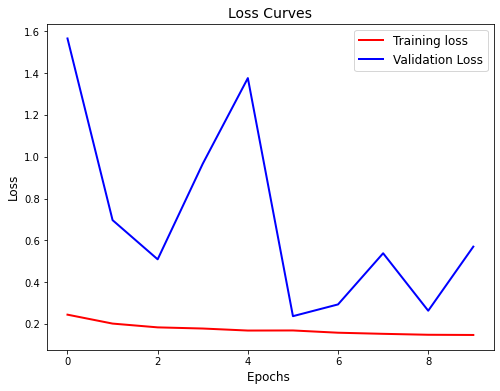

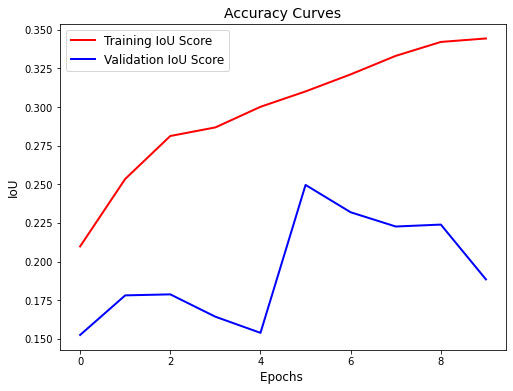

In [82]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=12)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.title('Loss Curves',fontsize=14)
  
# IOU Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['iou_score'],'r',linewidth=2.0)
plt.plot(history.history['val_iou_score'],'b',linewidth=2.0)
plt.legend(['Training IoU Score', 'Validation IoU Score'],fontsize=12)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('IoU',fontsize=12)
plt.title('Accuracy Curves',fontsize=14)